<a href="https://colab.research.google.com/github/suchita-shakya/Infinite-Claims-Categorization-Project/blob/main/ClaimsClassification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [40]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [5]:
import pandas as pd


In [14]:
inpatient = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/Claims Classification/Dataset/Train/176549_DE1_0_2008_to_2010_Inpatient_Claims_Sample_1/Inpatient.csv')   # Adjust filename
outpatient = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/Claims Classification/Dataset/Train/176616_DE1_0_2008_to_2010_Outpatient_Claims_Sample_1/Outpatient.csv')
#beneficiary_2008 = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/Claims Classification/Dataset/Train/176541_DE1_0_2008_Beneficiary_Summary_File_Sample_1/DE1_0_2008_Beneficiary_Summary_File_Sample_1.csv')
#beneficiary_2009 = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/Claims Classification/Dataset/Train/176600_DE1_0_2009_Beneficiary_Summary_File_Sample_1/DE1_0_2009_Beneficiary_Summary_File_Sample_1.csv')
#beneficiary_2010 = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/Claims Classification/Dataset/Train/DE1_0_2010_Beneficiary_Summary_File_Sample_1/DE1_0_2010_Beneficiary_Summary_File_Sample_1.csv')


/tmp/ipython-input-1871311718.py:2: DtypeWarning: Columns (21,23,24,25,26,27) have mixed types. Specify dtype option on import or set low_memory=False.
  outpatient = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/Claims Classification/Dataset/Train/176616_DE1_0_2008_to_2010_Outpatient_Claims_Sample_1/Outpatient.csv')


In [15]:
# Add claim type labels
inpatient['claim_type'] = 'Inpatient'
outpatient['claim_type'] = 'Outpatient'
print(outpatient.head())
print(list(outpatient.columns))
#print(beneficiary_2010.head())
#print(list(beneficiary_2010.columns))

        DESYNPUF_ID           CLM_ID  SEGMENT  CLM_FROM_DT  CLM_THRU_DT  \
0  00013D2EFD8E45D1  542192281063886        1   20080904.0   20080904.0   
1  00016F745862898F  542272281166593        1   20090602.0   20090602.0   
2  00016F745862898F  542282281644416        1   20090623.0   20090623.0   
3  0001FDD721E223DC  542642281250669        1   20091011.0   20091011.0   
4  00024B3D2352D2D0  542242281386963        1   20080712.0   20080712.0   

  PRVDR_NUM  CLM_PMT_AMT  NCH_PRMRY_PYR_CLM_PD_AMT  AT_PHYSN_NPI  \
0    2600RA         50.0                       0.0  4.824842e+09   
1    3901GS         30.0                       0.0  2.963420e+09   
2    3939PG         30.0                       0.0  5.737808e+09   
3    3902NU         30.0                       0.0  1.233848e+09   
4    5200TV         30.0                       0.0  9.688809e+09   

   OP_PHYSN_NPI  ...  HCPCS_CD_37  HCPCS_CD_38 HCPCS_CD_39 HCPCS_CD_40  \
0           NaN  ...          NaN          NaN         NaN        

In [16]:
# Combine datasets
df = pd.concat([inpatient, outpatient], ignore_index=True)
#df_merged = df.merge(beneficiary_2008, on='BENE_ID', how='left') \
 #             .merge(beneficiary_2009, on='BENE_ID', how='left')
  #            .merge(beneficiary_2010, on='BENE_ID', how='left')

In [17]:
# Convert date columns to datetime
df['CLM_FROM_DT'] = pd.to_datetime(df['CLM_FROM_DT'], errors='coerce')
df['CLM_THRU_DT'] = pd.to_datetime(df['CLM_THRU_DT'], errors='coerce')

# Feature: Claim duration in days
df['claim_duration_days'] = (df['CLM_THRU_DT'] - df['CLM_FROM_DT']).dt.days


In [27]:
# ICD-9 Procedure Codes
icd_procedure_cols = [f'ICD9_PRCDR_CD_{i}' for i in range(1, 7)]

# HCPCS Procedure Codes
hcpcs_procedure_cols = [f'HCPCS_CD_{i}' for i in range(1, 46)]

# Combine all procedure columns
procedure_cols = icd_procedure_cols + hcpcs_procedure_cols

for procedure_code in procedure_cols:
    df[procedure_code] = df[procedure_code].astype('category').cat.codes



In [28]:
#diagcode
diagnosis_cols = [f'ICD9_DGNS_CD_{i}' for i in range(1, 11)]
for diagnosis_code in diagnosis_cols:
    df[diagnosis_code] = df[diagnosis_code].astype('category').cat.codes


In [20]:
df['claim_type_encoded'] = df['claim_type'].astype('category').cat.codes

In [39]:
df.to_csv('claims_final.csv', index=False)
df.head()

,DESYNPUF_ID,CLM_ID,SEGMENT,CLM_FROM_DT,CLM_THRU_DT,PRVDR_NUM,CLM_PMT_AMT,NCH_PRMRY_PYR_CLM_PD_AMT,AT_PHYSN_NPI,OP_PHYSN_NPI,...,HCPCS_CD_41,HCPCS_CD_42,HCPCS_CD_43,HCPCS_CD_44,HCPCS_CD_45,claim_type,NCH_BENE_PTB_DDCTBL_AMT,NCH_BENE_PTB_COINSRNC_AMT,claim_duration_days,claim_type_encoded
0,00013D2EFD8E45D1,196661176988405,1,1970-01-01 00:00:00.020100312,1970-01-01 00:00:00.020100313,2600GD,4000.0,0.0,3.139084e+09,NaN,...,NaN,NaN,NaN,NaN,NaN,Inpatient,NaN,NaN,0.0,0
1,00016F745862898F,196201177000368,1,1970-01-01 00:00:00.020090412,1970-01-01 00:00:00.020090418,3900MB,26000.0,0.0,6.476809e+09,NaN,...,NaN,NaN,NaN,NaN,NaN,Inpatient,NaN,NaN,0.0,0
2,00016F745862898F,196661177015632,1,1970-01-01 00:00:00.020090831,1970-01-01 00:00:00.020090902,3900HM,5000.0,0.0,6.119985e+08,6.119985e+08,...,NaN,NaN,NaN,NaN,NaN,Inpatient,NaN,NaN,0.0,0
3,00016F745862898F,196091176981058,1,1970-01-01 00:00:00.020090917,1970-01-01 00:00:00.020090920,3913XU,5000.0,0.0,4.971603e+09,NaN,...,NaN,NaN,NaN,NaN,NaN,Inpatient,NaN,NaN,0.0,0
4,00016F745862898F,196261176983265,1,1970-01-01 00:00:00.020100626,1970-01-01 00:00:00.020100701,3900MB,16000.0,0.0,6.408400e+09,1.960860e+09,...,NaN,NaN,NaN,NaN,NaN,Inpatient,NaN,NaN,0.0,0


Build a classification model

In [22]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report

In [30]:
# Features and target
date_features = ['claim_duration_days']
X = df[diagnosis_cols + procedure_cols + date_features]
y = df['claim_type_encoded']

In [31]:
# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [32]:
# Train model
model = RandomForestClassifier()
model.fit(X_train, y_train)

RandomForestClassifier()

In [33]:
y_pred = model.predict(X_test)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.98      0.97      0.97     13259
           1       1.00      1.00      1.00    158254

    accuracy                           1.00    171513
   macro avg       0.99      0.98      0.99    171513
weighted avg       1.00      1.00      1.00    171513



Visualization


              precision    recall  f1-score   support

   Inpatient       0.98      0.97      0.97     13259
  Outpatient       1.00      1.00      1.00    158254

    accuracy                           1.00    171513
   macro avg       0.99      0.98      0.99    171513
weighted avg       1.00      1.00      1.00    171513



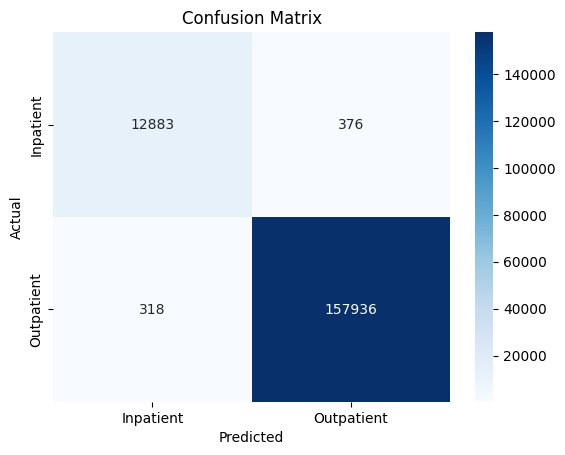

In [38]:
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# Print classification report
print(classification_report(y_test, y_pred, target_names=['Inpatient', 'Outpatient']))

# Plot confusion matrix
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Inpatient', 'Outpatient'], yticklabels=['Inpatient', 'Outpatient'])
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()